# Beam Characterization

FWHM and solid angles estimated from the beam fits files.  These examples should work with any beam file.

In [1]:
import pdb
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from astropy.io import fits
import warnings
warnings.filterwarnings("ignore")
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

In [2]:
def clean_nans(dirty_array, replacement_char=0.0):
    clean_array = dirty_array.copy()
    clean_array[np.isnan(dirty_array)] = replacement_char
    clean_array[np.isinf(dirty_array)] = replacement_char
    return clean_array

In [3]:
def dist_idl(n1, m1=None):
    ''' Copy of IDL's dist.pro
    Create a rectangular array in which each element is
    proportinal to its frequency'''

    if m1 == None:
        m1 = int(n1)

    x = np.arange(float(n1))
    for i in range(len(x)): x[i] = min(x[i], (n1 - x[i])) ** 2.

    a = np.zeros([int(n1), int(m1)])

    i2 = m1 // 2 + 1

    for i in range(i2):
        y = np.sqrt(x + i ** 2.)
        a[:, i] = y
        if i != 0:
            a[:, m1 - i] = y

    return a

In [4]:
def plot_bin_in_rings(beam, hd=None):
    pix = 1.0
    if hd:
        try:
            pix = hd['CDELT2'] * 3600.
        except:
            pix =( hd['PXSCAL1'] + hd['PXSCAL2'] )/2
    bs = np.shape(beam)
    out = np.roll(np.roll(beam, int(bs[0]//2+1), axis=1), int(bs[1]//2+1), axis=0)
    ds = dist_idl(bs[0], bs[1])
    ring = []
    x = np.arange(np.ceil(np.max(ds)))
    for i in x[:-1]:
        indi =( (ds >= i) & (ds < i+1) )
        ring.append(np.sum(out[indi])/np.sum(indi))
    return pix*x[:-1], ring, ds

In [5]:
def beam_solid_angle(beam, hd=None):
    pix = 1.0
    if hd:
        try:
            pix_sa = (hd['CDELT2'] / 360  * 2 * np.pi)**2  
        except:
            pix_sa = (((hd['PXSCAL1']+hd['PXSCAL2'])/2)/3600 / 360  * 2 * np.pi)**2  
    return np.sum(beam)/np.max(beam) * pix_sa 

In [6]:
def estimate_psf_details(psf_mod=None, hdm=None, psf_norm=None, hdn=None, psf_stack=None, hds=None, nx=50):
    nxp=0
    psfs = {}
    if type(psf_mod) is np.ndarray:
        psfs['model'] = {'psf': psf_mod, 'hd': hdm}
        nxp += 1
        
    if type(psf_norm) is np.ndarray:
        psfs['normalized_model'] = {'psf': psf_norm, 'hd': hdn}
        nxp += 1

    if type(psf_stack) is np.ndarray:
        psfs['stacked'] = {'psf': psf_stack, 'hd': hds}
        nxp += 1

    fig, axs = plt.subplots(1, nxp, figsize=(6*nxp, 4))
    i=0
    for k in psfs:
        psf = psfs[k]['psf']
        hd = psfs[k]['hd']
        x, psf_1d, ds = plot_bin_in_rings(psf, hd)
        solid_angle = beam_solid_angle(psf, hd)
        xint = np.linspace(x[0], x[-1], num=len(x)*nx, endpoint=True)
        fint = interp1d(x, psf_1d, kind='cubic')
        psfint = fint(xint)
        fwhm = xint[np.argmin(abs(psfint - np.max(psf)/2))]
        #axs[i].plot(xint,psfint, label='interpolated max/2 is = {:.5f}'.format(psfint[np.argmin(abs(psfint - np.max(psf)/2))]))
        #axs[i].scatter(x, psf_1d, label='max/2 is = {:.5f}'.format(np.max(psf)/2.0))
        if nxp == 1:
            axs.plot(xint,psfint, label=None)
            axs.scatter(x, psf_1d, label=None)
            axs.plot(x, psf_1d, label='fwhm={:.3f}, solid angle={:.4e}'.format(fwhm*2, solid_angle))
            axs.set_title(k)
            axs.legend(loc='upper right')
        else:
            axs[i].plot(xint,psfint, label=None)
            axs[i].scatter(x, psf_1d, label=None)
            axs[i].plot(x, psf_1d, label='fwhm={:.3f}, solid angle={:.4e}'.format(fwhm*2, solid_angle))
            axs[i].set_title(k)
            axs[i].legend(loc='upper right')            
        fwhm = xint[np.argmin(abs(psfint - np.max(psf)/2))]
        
        i += 1

# MIPS 24um

In [7]:
path_beams = os.environ['MAPSPATH'] + '/' + os.path.join('beams')
print(path_beams)

D:\maps/beams


In [8]:
# SPITZER MIPS 24
file_beam_mips24 = 'mips24_prf_mosaic_2.45_4x.fits'
file_beam_mips24_tinytim = 'mips24_prf_mosaic_stinytim_2.5_4x.fits'
file_beam_mips24_bcd_stinytim = 'mips24_prf_bcd_stinytim_4x.fits'

In [9]:
# SPITZER MIPS 24
beam_mips_model, hdm = fits.getdata(os.path.join(path_beams,file_beam_mips24), 0, header=True)

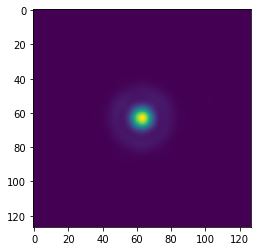

In [10]:
plt.imshow(beam_mips_model);

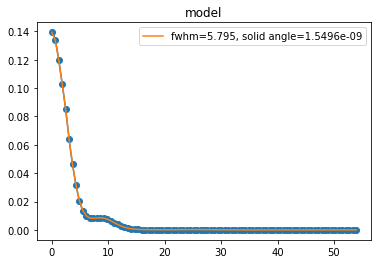

In [11]:
estimate_psf_details(psf_mod=beam_mips_model, hdm=hdm)

In [12]:
# SPITZER MIPS 24
beam_mips_model, hdm = fits.getdata(os.path.join(path_beams,file_beam_mips24_tinytim), 0, header=True)

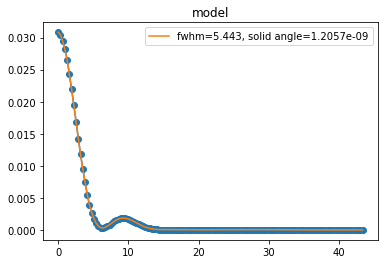

In [13]:
estimate_psf_details(psf_mod=beam_mips_model, hdm=hdm)

In [14]:
# SPITZER MIPS 24
beam_mips_model, hdm = fits.getdata(os.path.join(path_beams,file_beam_mips24_bcd_stinytim), 0, header=True)

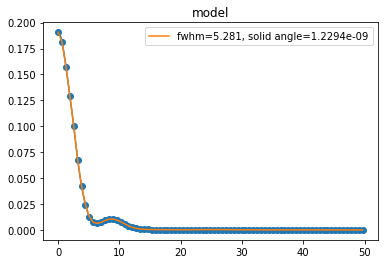

In [15]:
estimate_psf_details(psf_mod=beam_mips_model, hdm=hdm)

In [16]:
"Average MIPS FWHM = {0:0.2f} arcsec and solid angle = {1:0.3e}".format((5.281+5.443+5.795)/3, (1.229e-9 + 1.206e-9+1.550e-9)/3)

'Average MIPS FWHM = 5.51 arcsec and solid angle = 1.328e-09'

# PACS 100um

PACS beams found at [HEDAM](http://hedam.lam.fr/HELP/dataproducts/dmu18/dmu18_COSMOS/data/) via [HELP](https://herschel.sussex.ac.uk)

In [17]:
path_pacs_beam = os.environ['MAPSPATH'] + '/' + os.path.join('HELP','cosmos','beam')
print(path_pacs_beam)

D:\maps/HELP\cosmos\beam


In [18]:
# 100um "GREEN"
file_beam_green_model = 'COSMOS_PACS100_20160805_model_psf_100.fits'
file_beam_green_normalized = 'COSMOS_PACS100_20160805_model_normalized_psf_100.fits'
file_beam_green_stacked = 'COSMOS_PACS100_20160805_stacked_psf_100.fits'

In [19]:
# HELP COSMOS BEAMS "Green"
beam_green_model, hdg1 = fits.getdata(os.path.join(path_pacs_beam,file_beam_green_model), 0, header=True)
beam_green_normalized, hdg2 = fits.getdata(os.path.join(path_pacs_beam,file_beam_green_normalized), 0, header=True)
beam_green_stacked, hdg3 = fits.getdata(os.path.join(path_pacs_beam,file_beam_green_stacked), 0, header=True)

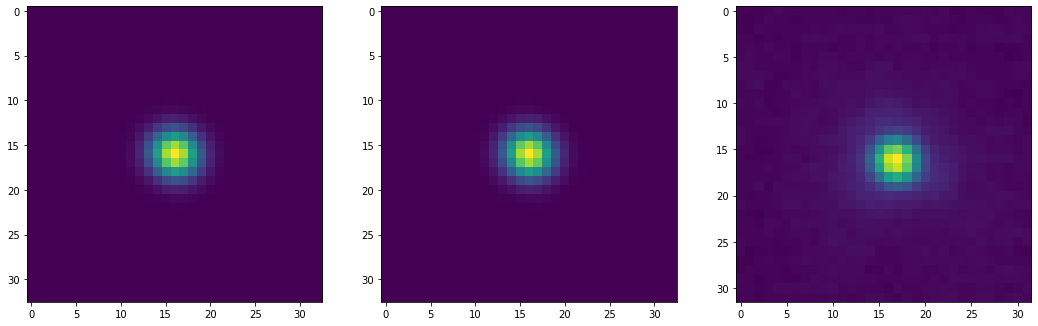

In [20]:
fig, axs = plt.subplots(1, 3, figsize=(18, 12))
axs[0].imshow(beam_green_model);
axs[1].imshow(beam_green_normalized);
axs[2].imshow(beam_green_stacked);

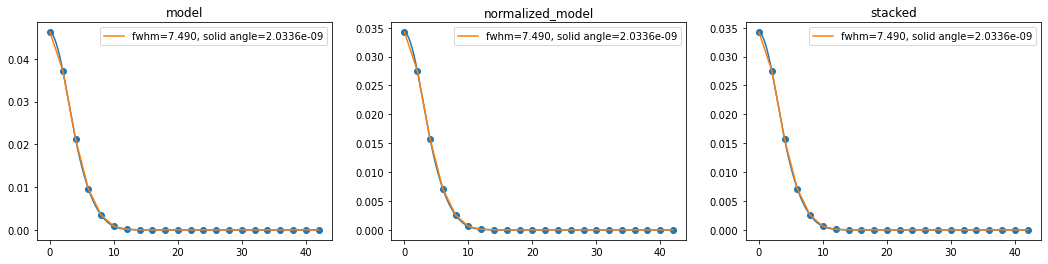

In [21]:
estimate_psf_details(psf_mod=beam_green_model, hdm=hdg1, psf_norm=beam_green_normalized, hdn=hdg2, psf_stack=beam_green_normalized, hds=hdg3)

# PACS 160um

In [22]:
# 160um "RED"
file_beam_red_model = 'COSMOS_PACS160_20160728_model_psf_160.fits'
file_beam_red_normalized = 'COSMOS_PACS160_20160805_model_normalized_psf_160.fits'
file_beam_red_stacked = 'COSMOS_PACS160_20160728_stacked_psf_160.fits'

In [23]:
# HELP COSMOS BEAMS "RED"
beam_red_model, hdr1 = fits.getdata(os.path.join(path_pacs_beam,file_beam_red_model), 0, header=True)
beam_red_normalized, hdr2 = fits.getdata(os.path.join(path_pacs_beam,file_beam_red_normalized), 0, header=True)
beam_red_stacked, hdr3 = fits.getdata(os.path.join(path_pacs_beam,file_beam_red_stacked), 0, header=True)

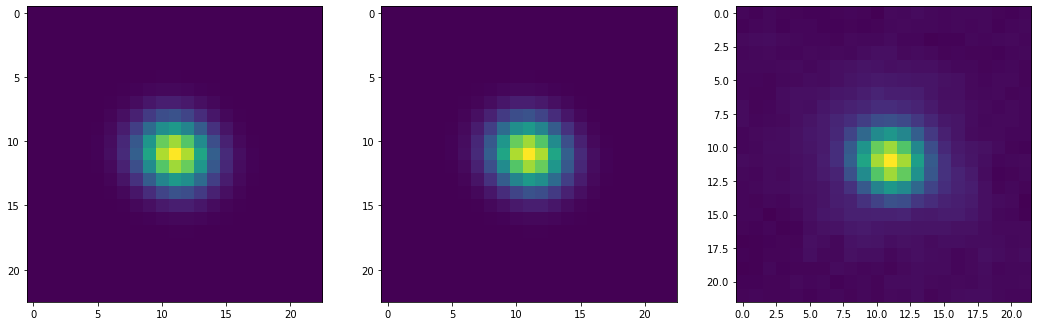

In [24]:
fig, axs = plt.subplots(1, 3, figsize=(18, 12))
axs[0].imshow(beam_red_model);
axs[1].imshow(beam_red_normalized);
axs[2].imshow(beam_red_stacked);

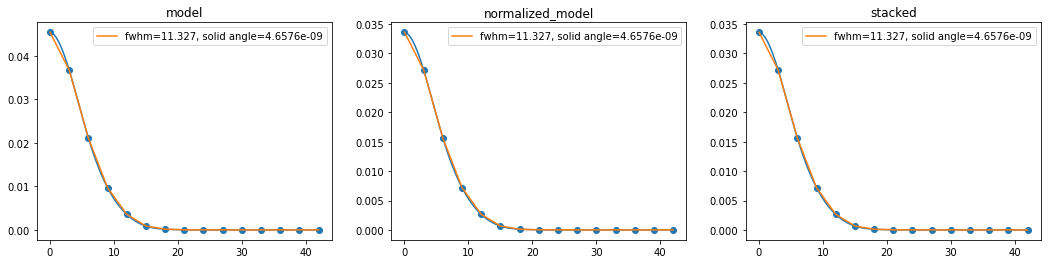

In [25]:
estimate_psf_details(psf_mod=beam_red_model, hdm=hdr1, psf_norm=beam_red_normalized, hdn=hdr2, psf_stack=beam_red_normalized, hds=hdr3)

# SPIRE 250um

In [26]:
file_psw = '0x5000241aL_PSW_pmcorr_1arcsec_norm_beam.fits'

In [27]:
beam_psw, hdpsw = fits.getdata(os.path.join(path_beams,file_psw), 0, header=True)

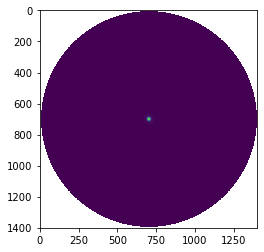

In [28]:
plt.imshow(beam_psw);

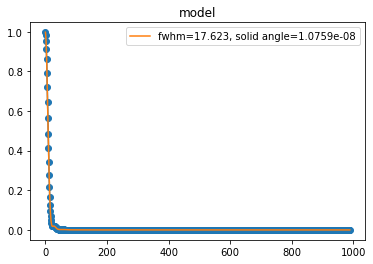

In [29]:
estimate_psf_details(psf_mod=clean_nans(beam_psw), hdm=hdpsw)

# SPIRE 350um

In [30]:
file_pmw = '0x5000241aL_PMW_pmcorr_1arcsec_norm_beam.fits'

In [31]:
beam_pmw, hdpmw = fits.getdata(os.path.join(path_beams,file_pmw), 0, header=True)

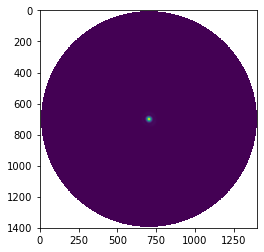

In [32]:
plt.imshow(beam_pmw);

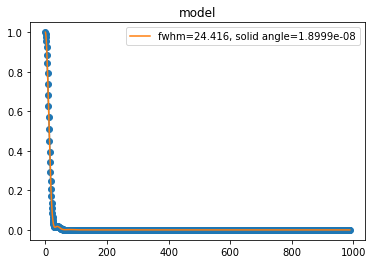

In [33]:
estimate_psf_details(psf_mod=clean_nans(beam_pmw), hdm=hdpmw)

# SPIRE 500um

In [34]:
file_plw = '0x5000241aL_PLW_pmcorr_1arcsec_norm_beam.fits'

In [35]:
beam_plw, hdplw = fits.getdata(os.path.join(path_beams,file_plw), 0, header=True)

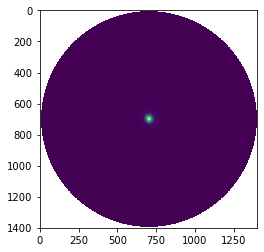

In [36]:
plt.imshow(beam_plw);

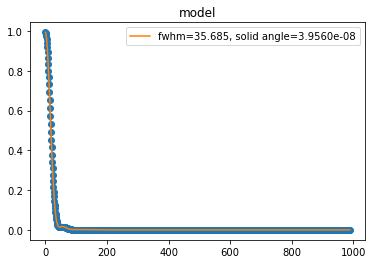

In [37]:
estimate_psf_details(psf_mod=clean_nans(beam_plw), hdm=hdplw)